# California House Price Prediction

This notebook predicts median house prices in California using the `housing.csv` dataset. We train Linear Regression and Random Forest models, combine them in an ensemble, and evaluate performance using RMSE, R², and MAPE. The dataset includes geographic, demographic, and economic features, with `median_house_value` as the target.

## Importing the libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_percentage_error

Imports essential libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), and machine learning (Scikit-learn). Sets Seaborn style for plots and ensures inline plotting in Jupyter.

## Load the Dataset

In [33]:
# Load the dataset
df = pd.read_csv('housing.csv')


Loads the California Housing dataset (housing.csv) into a Pandas DataFrame for analysis.

## Explore the dataset

In [34]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Displays the first five rows of the dataset to inspect its structure and contents.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Shows dataset information, including column names, data types, and non-null counts

In [36]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Lists data types of each column, confirming 9 numeric (float64) and 1 categorical (ocean_proximity) columns.

In [37]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Provides statistical summaries (mean, std, min, max, etc.) for numeric columns, highlighting ranges and potential outliers

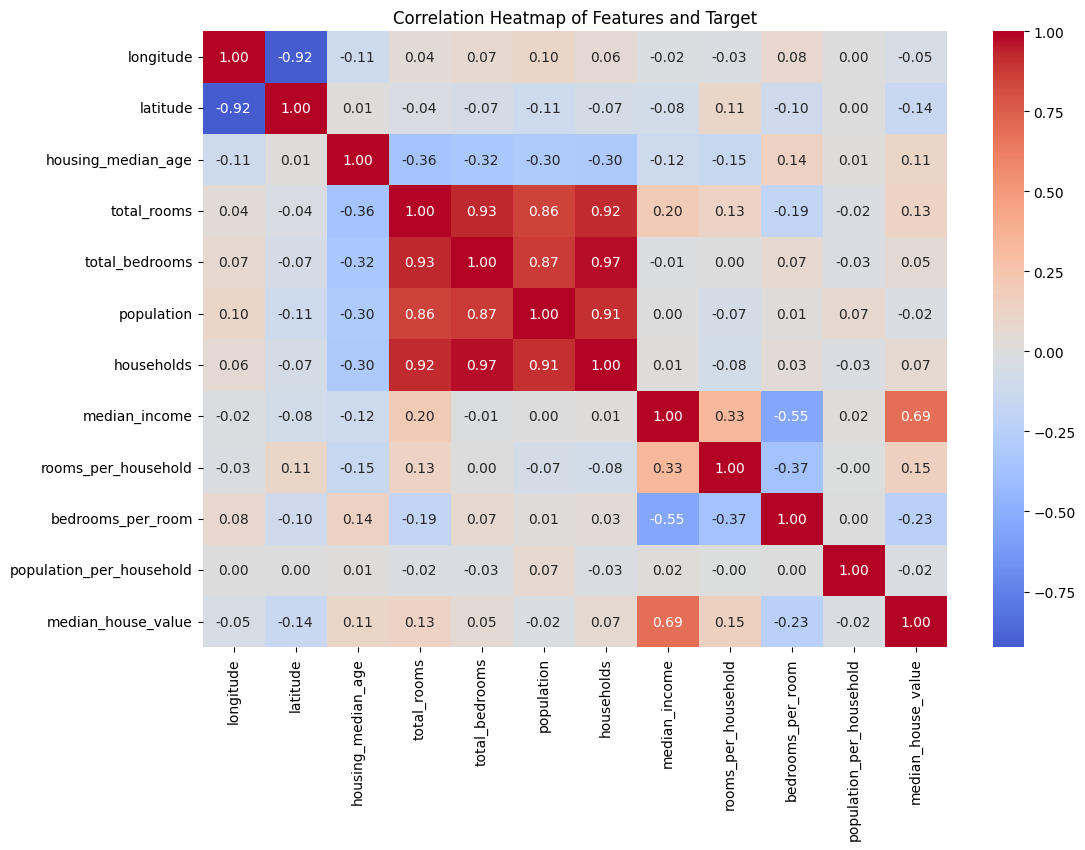

In [56]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df[features + ['median_house_value']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Features and Target')
plt.show()

The heatmap below visualizes correlations between numeric features and `median_house_value`. Strong correlations (positive or negative) indicate features that may influence house prices significantly.

## Cleaning the data and handling missing values 

In [38]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Checks for missing values, confirming 207 missing entries in total_bedrooms (1% of data).

In [39]:
# Impute missing values in total_bedrooms with median
imputer = SimpleImputer(strategy='median')
df['total_bedrooms'] = imputer.fit_transform(df[['total_bedrooms']])

Imputes missing total_bedrooms values with the median to handle missing data robustly.

In [40]:
df['total_bedrooms'].isnull().sum()

np.int64(0)

Confirms no missing values remain in total_bedrooms after imputation.

## Feature Engineering

In [41]:
# Rooms per household
df['rooms_per_household'] = df['total_rooms'] / df['households']

new feature, rooms_per_household, by dividing total_rooms by households to capture average rooms per household.

In [42]:
# Bedrooms per room
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']

bedrooms_per_room, the ratio of total_bedrooms to total_rooms, to represent the proportion of bedrooms.

In [43]:
# Population per household
df['population_per_household'] = df['population'] / df['households']

population_per_household, dividing population by households to reflect average household size.

## Modeling 

In [44]:
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
            'population', 'households', 'median_income', 'rooms_per_household',
            'bedrooms_per_room', 'population_per_household']
X = df[features]
y = df['median_house_value']

Selects 11 numeric features and defines median_house_value as the target variable for modeling.

In [45]:
print("Processed Data Shape:", X.shape)
print("Target Shape:", y.shape)
X.head()

Processed Data Shape: (20640, 11)
Target Shape: (20640,)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,6.281853,0.172096,2.181467


Prints the shapes of the feature matrix (20,640 rows, 11 columns) and target vector (20,640 rows). Displays the first five rows of features.

In [46]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape: (16512, 11)
Test set shape: (4128, 11)


Splits data into 80% training (16,512 rows) and 20% testing (4,128 rows) sets. Scales features using StandardScaler for consistent model input.

In [47]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

Trains a Linear Regression model on scaled training data to predict house prices, assuming linear relationships.

In [48]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  

RandomForestRegressor(random_state=42)

Trains a Random Forest Regressor with 100 trees on unscaled training data to capture non-linear patterns.

In [49]:
# Predictions from both models
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)

# Ensemble: Average predictions
y_pred_ensemble = (y_pred_lr + y_pred_rf) / 2

## Evaluate the model

In [50]:
# Evaluate RMSE (as before)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

In [51]:
# Calculate R² Score (proportion of variance explained)
r2_lr = r2_score(y_test, y_pred_lr)
r2_rf = r2_score(y_test, y_pred_rf)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

In [52]:
# Calculate MAPE (mean absolute percentage error)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr) * 100  # Convert to percentage
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf) * 100
mape_ensemble = mean_absolute_percentage_error(y_test, y_pred_ensemble) * 100

In [53]:
# Print results
print("Model Performance Comparison:")
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Ensemble'],
    'RMSE ($)': [rmse_lr, rmse_rf, rmse_ensemble],
    'R² Score': [r2_lr, r2_rf, r2_ensemble],
    'MAPE (%)': [mape_lr, mape_rf, mape_ensemble]
})
print(comparison_df.round(2))

Model Performance Comparison:
               Model  RMSE ($)  R² Score  MAPE (%)
0  Linear Regression  74252.14      0.58     31.52
1      Random Forest  50948.58      0.80     19.22
2           Ensemble  58157.52      0.74     23.62


Evaluates Linear Regression, Random Forest, and ensemble models using RMSE, R², and MAPE metrics on the test set. Prints results for comparison.

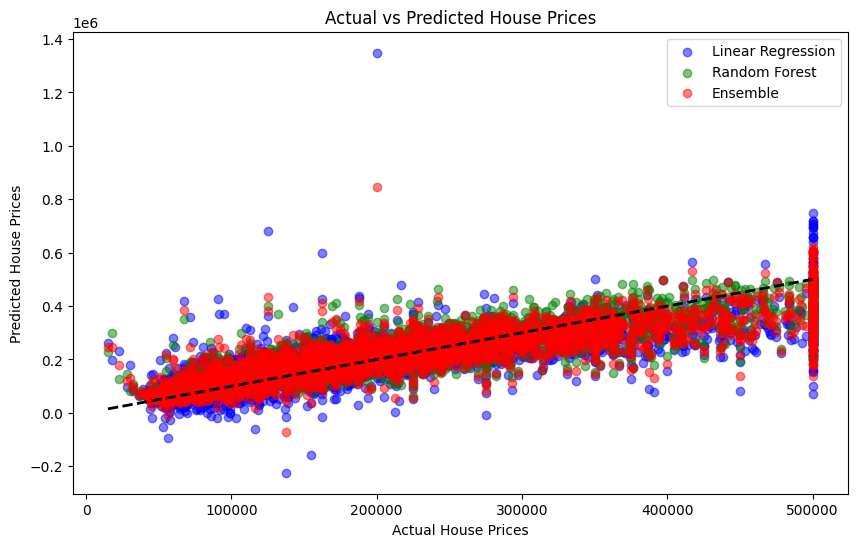

In [55]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression', alpha=0.5)
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest', alpha=0.5)
plt.scatter(y_test, y_pred_ensemble, color='red', label='Ensemble', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.show()